In [2]:
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from utils import cfg, load_data, get_labels, get_hypothesis, clean_str, tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

In [3]:
def clean_data(data: dict) -> None:
    for i in range(len(data['documents'])):
        data['documents'][i]['text'] = clean_str(data['documents'][i]['text'])
        data['documents'][i]['text'] = tokenize(data['documents'][i]['text'])

In [4]:
# x is document text (vectorized to tfidf) + (concatnate) hypothesis text (vectorized to tfidf)
# y is the label of the hypothesis (0 or 1 or 2) -> ('NotMentioned': 0,'Entailment': 1, 'Contradiction': 2,)
# For each documnet there are 17 entries

# Vectorized form of tfidf means that each unique word is converted to its tfidf value and then stored in vector format

def get_XY(data: dict, tfidf: TfidfVectorizer, hypothesis: dict, labels: dict) -> (list, list):
    
    X = []
    Y = []
    for i in range(len(data["documents"])):

        premise = data["documents"][i]["text"]
        premise_vector = tfidf.transform([premise])
        
        for key, val in hypothesis.items():
            hypothesis_vector = tfidf.transform([val])

            input_vec = sp.hstack([premise_vector, hypothesis_vector])
            X += [input_vec]
            Y += [labels[data["documents"][i]["annotation_sets"][0]["annotations"][key]["choice"]]]
    
    return sp.vstack(X), Y

In [5]:
train = load_data(cfg['train_path'])
clean_data(train)

In [6]:
hypothesis = get_hypothesis(train)
labels = get_labels()

In [7]:
print(labels)
print(hypothesis)

{'NotMentioned': 0, 'Entailment': 1, 'Contradiction': 2}
{'nda-11': "receiving party shall not reverse engineer any objects which embody disclosing party's confidential information.", 'nda-16': 'receiving party shall destroy or return some confidential information upon the termination of agreement.', 'nda-15': 'agreement shall not grant receiving party any right to confidential information.', 'nda-10': 'receiving party shall not disclose the fact that agreement was agreed or negotiated.', 'nda-2': 'confidential information shall only include technical information.', 'nda-1': 'all confidential information shall be expressly identified by the disclosing party.', 'nda-19': 'some obligations of agreement may survive termination of agreement.', 'nda-12': 'receiving party may independently develop information similar to confidential information.', 'nda-20': 'receiving party may retain some confidential information even after the return or destruction of confidential information.', 'nda-3': '

In [8]:
# all_text = ""

# for i in range(len(train["documents"])):
#     all_text += train["documents"][i]["text"] + " "

# tfidf = TfidfVectorizer()
# tfidf.fit([all_text])

In [11]:
# Create a list of all document texts
all_text = [doc['text'] for doc in train['documents']]

# Initialize and fit TF-IDF vectorizer on the entire corpus of documents
tfidf = TfidfVectorizer()
tfidf.fit(all_text)  # Now each document is treated individually

TfidfVectorizer()

In [12]:
X_train, Y_train = get_XY(train, tfidf, hypothesis, labels=labels)

In [13]:
from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(X_train, Y_train)

SVC(kernel='linear')

In [14]:
# dev = load_data(cfg['dev_path'])
test = load_data(cfg['test_path'])
clean_data(test)
X_dev, Y_dev = get_XY(test, tfidf, hypothesis, labels=labels)

In [15]:
print(X_dev.shape)
print(len(Y_dev))

(2091, 21054)
2091


In [16]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


Accuracy: 0.6815
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       903
           1       0.72      0.77      0.74       968
           2       0.48      0.54      0.51       220

    accuracy                           0.68      2091
   macro avg       0.63      0.64      0.64      2091
weighted avg       0.68      0.68      0.68      2091



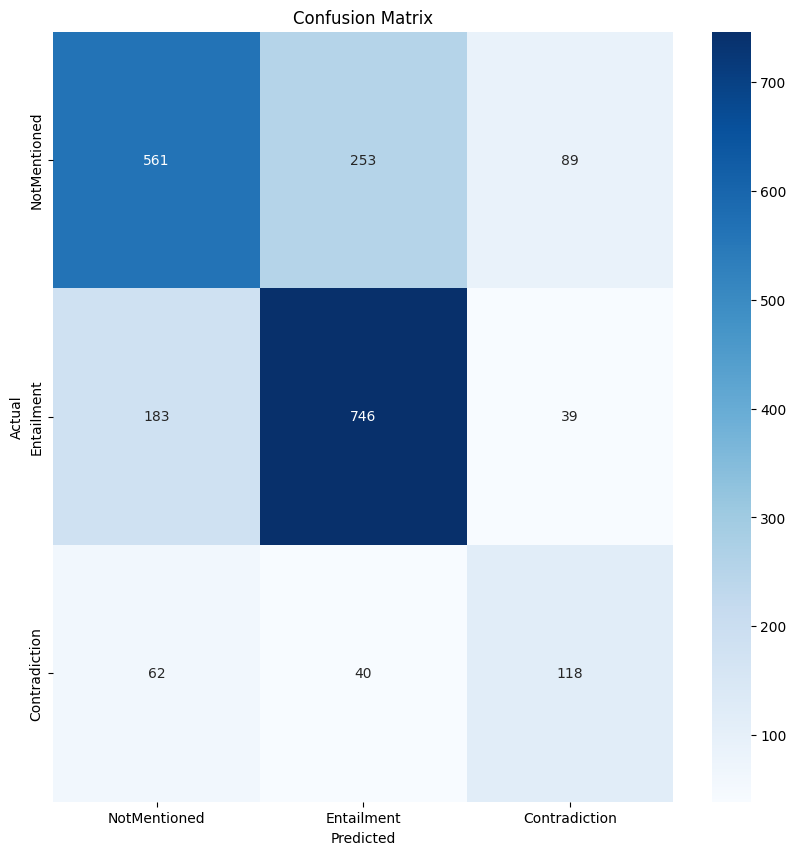

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Calculate and print the accuracy
accuracy = model.score(X_dev, Y_dev)
print(f'Accuracy: {accuracy:.4f}')

# Make predictions on the validation set
Y_pred = model.predict(X_dev)

# Generate a classification report
report = classification_report(Y_dev, Y_pred)
print("Classification Report:")
print(report)

# Generate a confusion matrix
cm = confusion_matrix(Y_dev, Y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NotMentioned', 'Entailment', 'Contradiction'], yticklabels=['NotMentioned', 'Entailment', 'Contradiction'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()  # Display the plot

# Optionally, save the confusion matrix plot
# plt.savefig('doc_tf-idf_svm.png')